In [348]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import pickle
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tensorflow import keras

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)


In [84]:
season = "2021-22"
sbs = pd.read_csv(data_dir / "score_by_score" / (eval_season + ".csv"))
playstats = pd.read_csv(data_dir / "playstats" / (eval_season + ".csv"))
rankings = pd.read_csv(data_dir / "rankings" / (eval_season + ".csv"))


In [86]:
model = keras.models.load_model(hoops_dir / "model/models/16_32_8|2|3|2.5e-06|home_lead_time_left_home_ranking_vis_ranking_home_lead_pml")
scaler = pickle.load(open(hoops_dir / "model/scalers/16_32_8|2|3|2.5e-06|home_lead_time_left_home_ranking_vis_ranking_home_lead_pml", "rb"))


In [602]:
sbs_reg = sbs.loc[sbs['time'] < 48].copy(deep=True)
features = ['home_lead', 'log_time_left', 'home_ranking', 'vis_ranking', 'home_lead_per_root_minute']
sbs_reg['home_lead'] = sbs_reg['home_score'] - sbs_reg['vis_score']
sbs_reg['log_time_left'] = np.log(48 - sbs_reg['time'])
sbs_reg['ppm'] = (sbs_reg['home_score'] + sbs_reg['vis_score']) / sbs_reg['time']
sbs_reg['home_lead_per_root_minute'] = sbs_reg['home_lead'] / np.sqrt(48-sbs_reg['time'])
sbs_reg['formatted_time'] = "Q" + (1 + sbs_reg.time // 12).astype(int).astype(str) + " " + (sbs_reg.time % 12 // 1).astype(int).astype(str) + ":" + (60*(sbs_reg.time % 12 % 1)).astype(int).astype(str)


In [603]:
sbs_reg.loc[(sbs_reg['home'] == "DET") | (sbs_reg['vis'] == "DET")].drop_duplicates('game_id').sort_values("date").tail()

,game_id,date,home,vis,time,home_score,vis_score,home_win,home_lead,log_time_left,ppm,home_lead_per_root_minute,formatted_time
34320,22100915,2022-02-27,CHA,DET,0.0,0,0,False,0,3.871201,NaN,0.0,Q1 0:0
77873,22100926,2022-03-01,WAS,DET,0.0,0,0,True,0,3.871201,NaN,0.0,Q1 0:0
90780,22100942,2022-03-03,TOR,DET,0.0,0,0,False,0,3.871201,NaN,0.0,Q1 0:0
109623,22100946,2022-03-04,DET,IND,0.0,0,0,True,0,3.871201,NaN,0.0,Q1 0:0
97299,22100968,2022-03-07,DET,ATL,0.0,0,0,True,0,3.871201,NaN,0.0,Q1 0:0


In [620]:
gameid = 22100946
game_sbs = sbs_reg.loc[sbs_reg['game_id'] == gameid].reset_index(drop=True).copy(deep=True)
last_event = game_sbs.iloc[-1]
home, vis, game_date, home_score, vis_score = last_event[['home', 'vis', 'date', 'home_score', 'vis_score']]
home_ranking = rankings.loc[(rankings['date'] == game_date) & (rankings['team'] == home), 'ranking']
vis_ranking = rankings.loc[(rankings['date'] == game_date) & (rankings['team'] == vis), 'ranking']
game_sbs['home_ranking'] = home_ranking.iloc[0]
game_sbs['vis_ranking'] = vis_ranking.iloc[0]
game_features = scaler.transform(game_sbs[features].to_numpy())
home_probs = model.predict(game_features)[:,0].round(3)

# Put in terms of winner
winner = home if home_score > vis_score else vis
winner_probs = home_probs if winner == home else 1-home_probs
winner_lead = game_sbs['home_lead'] if winner == home else 1-game_sbs['home_lead']

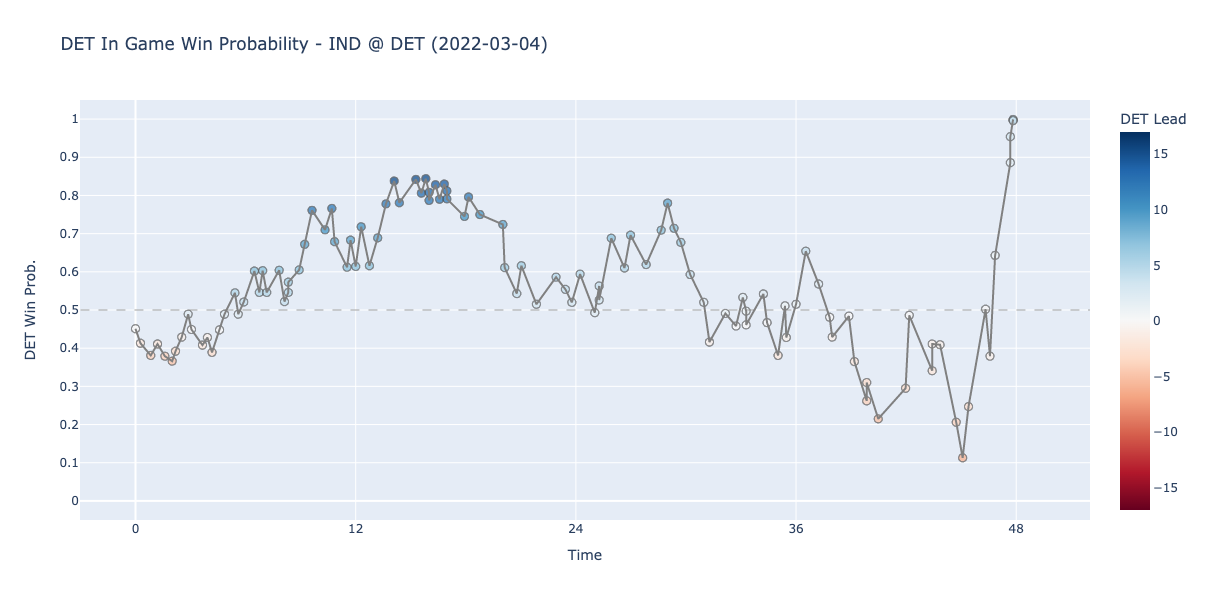

In [622]:
max_lead = max(-winner_lead.min(), winner_lead.max()) + 2
line = px.line(x=game_sbs['time'], y=winner_probs, color_discrete_sequence=["gray"])
scatter = px.scatter(game_sbs, x='time', y=winner_probs, color=winner_lead, hover_data={'formatted_time': True})
fig = go.Figure(data=scatter.data + line.data)
fig.update_coloraxes(colorbar_title=f"{winner} Lead", cmin=-max_lead, cmax=max_lead, colorscale="RdBu")
fig.update_traces(marker={'size': 8, 'line_width': 1, 'opacity': .75})
fig.update_traces(hovertemplate='Time: %{customdata.0} <br>' + winner + ' Win Prob: %{y} <br>' + winner + ' Lead: %{marker.color}')
fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text=f"{winner} Win Prob.", range=(-.05, 1.05))
fig.update_layout(width=1000, height=600)
fig.update_layout(title=f"{winner} In Game Win Probability - {vis} @ {home} ({game_date})",)
fig.update_layout(xaxis = {'tickmode': 'linear', 'tick0': 0, 'dtick': 12})
fig.update_layout(yaxis = {'tickmode': 'linear', 'tick0': 0, 'dtick': .1})
fig.add_shape(type='line', x0=-3, x1=52, y0=0.5, y1=0.5, line_color='gray', line_dash='dash', line_width=0.75)
fig.show()
pio.write_html(fig, file='_includes/figure.html', auto_open=False)
